In [ ]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

In [1]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext Cython

In [3]:
# PASSWORDS AND STUFF HERE

In [4]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [5]:
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

In [6]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

39


In [7]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=128):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            w = 512 + 2 * highpass
            if start - w > 0:
                raw   = self.data[start - w:stop]
                spec  = fwd_spectrogram(raw, win=w)[:, 0:256] 
                t,d   = spec.shape
                if t >= self.win:
                    current = []        
                    for i in range(self.win, t + 1, self.win // 2):
                        x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                        mu     = np.mean(x)
                        std    = np.std(x) + 1.0
                        window = (x - mu) / std
                        current.append(window)
                    self.i += 1
                    return np.stack(current)
                else:
                    self.i += 1
                    return None
            else:
                self.i += 1
                return None
        else:
            raise StopIteration                    
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [9]:
encoder = load_model('../models/convnet_v5/v5.1/encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])
    print(path, len(latent), len(regions_by_file[path]))

Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261101C.m4a 1 1
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261103C.m4a 2 1
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06111101.m4a 9 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05271101.m4a 26 17
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05311101.m4a 36 10
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05301101.m4a 61 25
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06271101.m4a 65 4
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/08031101.m4a 79 14
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06231101C.m4a 82 3
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05141101.m4a 88 6
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05281102.m4a 97 9
Infile converted from .m4a to ".wav"
data read in!

In [10]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

556


556


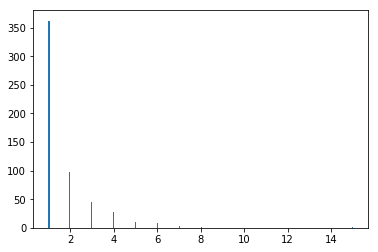

In [11]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [12]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float
GAP_PENALTY = 10.0

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 10), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dist = euc(x[i - 1, :], y[j - 1, :])            
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                GAP_PENALTY + dp[i - 1][j    ],
                GAP_PENALTY + dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        if i < j:
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

556
0 / 556
10 / 556
20 / 556
30 / 556
40 / 556
50 / 556
60 / 556
70 / 556
80 / 556
90 / 556
100 / 556
110 / 556
120 / 556
130 / 556
140 / 556
150 / 556
160 / 556
170 / 556
180 / 556
190 / 556
200 / 556
210 / 556
220 / 556
230 / 556
240 / 556
250 / 556
260 / 556
270 / 556
280 / 556
290 / 556
300 / 556
310 / 556
320 / 556
330 / 556
340 / 556
350 / 556
360 / 556
370 / 556
380 / 556
390 / 556
400 / 556
410 / 556
420 / 556
430 / 556
440 / 556
450 / 556
460 / 556
470 / 556
480 / 556
490 / 556
500 / 556
510 / 556
520 / 556
530 / 556
540 / 556
550 / 556


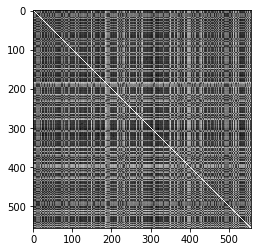

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

max_val = np.max([d for d in distances.flatten() if not np.isinf(d)])
for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isnan(distances[i][j]) or np.isinf(distances[i][j]):
            distances[i][j] = max_val
plt.imshow(distances, cmap='gray')
plt.show()

In [14]:
pickle.dump(distances, open( "distances_normal.p", "wb" ))

In [15]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

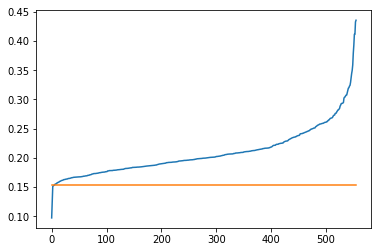

In [32]:
import numpy as np

def min_k(x, x_id, k):
    val = [(v, i) for i, v in enumerate(list(x)) if i != x_id]
    val = sorted(val, key=lambda x: x[0])
    return val[0:k]

def is_max(i, knn, densities):
    maximum = True
    for k in knn:
        maximum = maximum and densities[i] > densities[k[1]] 
    return maximum
    
def dense_region(i, knn):
    knn_ids = [x[1] for x in knn]
    knn_ids.append(i)
    return knn_ids
    
def density(x, k):
    knns = []
    for i in range(0, len(x)):
        knns.append(min_k(x[i, :], i, k))
    dense = np.zeros(len(knns))
    for i, knn in enumerate(knns):
        dense[i] = 1.0 / knn[-1][0]
    th = np.percentile(dense, 1)
    
    plt.plot(sorted(dense))
    plt.plot(np.ones(len(dense)) * th)
    plt.show()
    
    return [dense_region(i, knn) for i, knn in enumerate(knns) if is_max(i, knn, dense) and dense[i] >= th]

clusters = density(distances, 3)

In [33]:
c = [[] for i in range(len(clusters))]
for cluster_id, x in enumerate(clusters):
    for i in x:        
        latent[i][1:][0]['cluster'] = cluster_id
        c[cluster_id].append(latent[i][1:][0])

In [34]:
final_clustering = c
pickle.dump(final_clustering, open( "final_clustering.p", "wb" ) )
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

9
[4, 4, 4, 4, 4, 4, 4, 4, 4]
36


In [35]:
from scipy.io import wavfile
import sys
from google.cloud import storage
import pickle
import random 

final_clustering = pickle.load(open( "final_clustering.p", "rb" ))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))

cache = {}
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

cx = 0
skip = 0
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {} {}".format(n, cx))
        audio = []
        sampled_cluster = cluster.copy()
        random.shuffle(sampled_cluster)
        sampled_cluster = sampled_cluster[:10]
        for i, region in enumerate(sampled_cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            if path in cache:
                stream = cache[path]
            else:                
                with open("/tmp/audio.m4a", "wb") as file_obj:
                    blob = bucket.blob(path)
                    blob.download_to_file(file_obj)
                stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
                cache[path] = stream              
                print(sys.getsizeof(cache))
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
        audio = np.array(audio, dtype=audio[0].dtype)
        wavfile.write('../data/results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1

[4, 4, 4, 4, 4, 4, 4, 4, 4]
CLUSTERS:  9
Cluster: 4 0
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
288
Cluster: 4 1
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
480
Infile converted from .m4a to ".wav"
data read in!
480
Cluster: 4 2
Infile converted from .m4a to ".wav"
data read in!
480
Cluster: 4 3
Infile converted from .m4a to ".wav"
data read in!
480
Infile converted from .m4a to ".wav"
data read in!
480
Cluster: 4 4
Infile converted from .m4a to ".wav"
data read in!
480
Infile converted from .m4a to ".wav"
data read in!
864
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 4 5
Infile converted from .m4a to ".wav"
data read in!
864
Infile converted from .m4a to ".wav"
data read in!
864
Cluster: 4 6
Cluster: 4 7
Infile converted from .m4a to 

In [33]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

2840


In [34]:
import pickle
final_clustering = pickle.load(open( "final_clustering.p", "rb" ))

with db.connect() as conn:
    id = max_id + 1
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'density_dtw_th_convnet_v5_1', r['cluster'])        
            conn.execute(query)  
            id += 1